In [ ]:
 import pickle
import keras
import matplotlib.pyplot as plt
import numpy as np
import os
#from keras.utils import multi_gpu_model
from keras.callbacks import LearningRateScheduler
from keras.layers import Conv1D, Dense, Dropout, Flatten, MaxPooling1D
from tensorflow.keras import Input, models,Model
from keras.regularizers import l2
from scipy.interpolate import splev, splrep
import pandas as pd

In [ ]:
base_dir = "/content/drive/MyDrive/dataset/osa_data"

In [ ]:
ir = 3 # interpolate interval
before = 2
after = 2

# normalize
scaler = lambda arr: (arr - np.min(arr)) / (np.max(arr) - np.min(arr))

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def load_data():
    tm = np.arange(0, (before + 1 + after) * 60, step=1 / float(ir))

    with open(os.path.join(base_dir, "apnea-ecg.pkl"), 'rb') as f: # read preprocessing result
        apnea_ecg = pickle.load(f)

    x_train = []
    o_train, y_train = apnea_ecg["o_train"], apnea_ecg["y_train"]
    groups_train = apnea_ecg["groups_train"]
    for i in range(len(o_train)):
        (rri_tm, rri_signal), (ampl_tm, ampl_siganl) = o_train[i]
		# Curve interpolation
        rri_interp_signal = splev(tm, splrep(rri_tm, scaler(rri_signal), k=3), ext=1)
        ampl_interp_signal = splev(tm, splrep(ampl_tm, scaler(ampl_siganl), k=3), ext=1)
        x_train.append([rri_interp_signal, ampl_interp_signal])
    x_train = np.array(x_train, dtype="float32").transpose((0, 2, 1)) # convert to numpy format
    y_train = np.array(y_train, dtype="float32")

    x_test = []
    o_test, y_test = apnea_ecg["o_test"], apnea_ecg["y_test"]
    groups_test = apnea_ecg["groups_test"]
    for i in range(len(o_test)):
        (rri_tm, rri_signal), (ampl_tm, ampl_siganl) = o_test[i]
		# Curve interpolation
        rri_interp_signal = splev(tm, splrep(rri_tm, scaler(rri_signal), k=3), ext=1)
        ampl_interp_signal = splev(tm, splrep(ampl_tm, scaler(ampl_siganl), k=3), ext=1)
        x_test.append([rri_interp_signal, ampl_interp_signal])
    x_test = np.array(x_test, dtype="float32").transpose((0, 2, 1))
    y_test = np.array(y_test, dtype="float32")

    return x_train, y_train, groups_train, x_test, y_test, groups_test

Creation of LeNet CNN model

In [ ]:
def create_model(input_shape, weight=1e-3):
    inputs = Input(shape=input_shape)

	# Conv1
    x = Conv1D(32, kernel_size=5, strides=2, padding="valid", activation="relu", kernel_initializer="he_normal",
               kernel_regularizer=l2(weight), bias_regularizer=l2(weight))(inputs)
    x = MaxPooling1D(pool_size=3)(x)

	# Conv3
    x = Conv1D(64, kernel_size=5, strides=2, padding="valid", activation="relu", kernel_initializer="he_normal",
               kernel_regularizer=l2(1e-3), bias_regularizer=l2(weight))(x)
    x = MaxPooling1D(pool_size=3)(x)

    x = Dropout(0.8)(x) # Avoid overfitting

	# FC6
    x = Flatten()(x)
    x = Dense(32, activation="relu")(x)
    outputs = Dense(2, activation="softmax")(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model


In [ ]:
def lr_schedule(epoch, lr):
    if epoch > 70 and \
            (epoch - 1) % 10 == 0:
        lr *= 0.1
    print("Learning rate: ", lr)
    return lr

In [ ]:
def plot(history):
	#Plot performance curve"""
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    import matplotlib.pyplot as plt



In [ ]:
if __name__ == "__main__":
    x_train, y_train, groups_train, x_test, y_test, groups_test = load_data()

    y_train = keras.utils.to_categorical(y_train, num_classes=2) # Convert to two categories
    y_test = keras.utils.to_categorical(y_test, num_classes=2)

    print("train num:", len(y_train))
    print("test num:", len(y_test))

    model = create_model(input_shape=x_train.shape[1:])
    model.summary()

train num: 16709
test num: 16945
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 900, 2)]          0         
                                                                 
 conv1d (Conv1D)             (None, 448, 32)           352       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 149, 32)          0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 73, 64)            10304     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 24, 64)           0         
 1D)                                                             
                                                                 
 dropout (Dropout)          

In [ ]:
from keras.utils import plot_model

plot_model(model, "model.png") # Plot model

#model = keras.multi_gpu_model(model, gpus=2) # Multi-gpu acceleration (optional)
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy'])

lr_scheduler = LearningRateScheduler(lr_schedule) # Dynamic adjustment learning rate
history = model.fit(x_train, y_train, batch_size=128, epochs=100, validation_data=(x_test, y_test),
                        callbacks=[lr_scheduler])
model.save(os.path.join("models", "model.final.h5")) # Save training model

Learning rate:  0.0010000000474974513
Epoch 1/100
131/131 [==============================] - 10s 67ms/step - loss: 0.8251 - accuracy: 0.6161 - val_loss: 0.6440 - val_accuracy: 0.7216 - lr: 0.0010
Learning rate:  0.0010000000474974513
Epoch 2/100
131/131 [==============================] - 9s 68ms/step - loss: 0.5977 - accuracy: 0.7536 - val_loss: 0.5238 - val_accuracy: 0.7818 - lr: 0.0010
Learning rate:  0.0010000000474974513
Epoch 3/100
131/131 [==============================] - 10s 76ms/step - loss: 0.5246 - accuracy: 0.7900 - val_loss: 0.4910 - val_accuracy: 0.8171 - lr: 0.0010
Learning rate:  0.0010000000474974513
Epoch 4/100
131/131 [==============================] - 9s 66ms/step - loss: 0.4918 - accuracy: 0.8091 - val_loss: 0.5178 - val_accuracy: 0.7675 - lr: 0.0010
Learning rate:  0.0010000000474974513
Epoch 5/100
131/131 [==============================] - 8s 58ms/step - loss: 0.4725 - accuracy: 0.8185 - val_loss: 0.4505 - val_accuracy: 0.8273 - lr: 0.0010
Learning rate:  0.00100

Testing our model

530/530 [==============================] - 3s 6ms/step - loss: 0.3297 - accuracy: 0.8744
Test loss:  0.32965606451034546
Accuracy:  0.8743582367897034
530/530 [==============================] - 5s 9ms/step


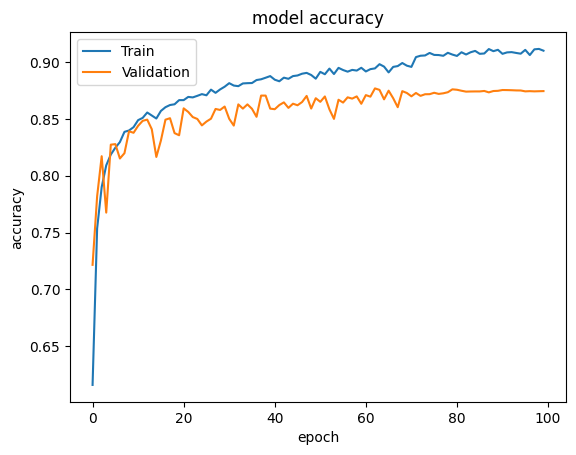

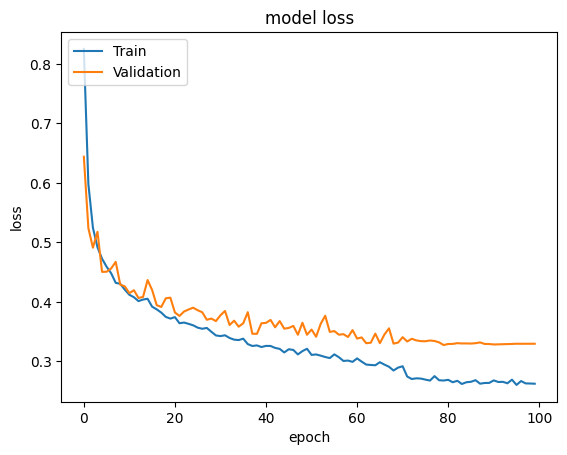

In [ ]:
    loss, accuracy = model.evaluate(x_test, y_test) # test the model
    print("Test loss: ", loss)
    print("Accuracy: ", accuracy)

    # save prediction score
    y_score = model.predict(x_test)
    #output = pd.DataFrame({"y_true": y_test[:, 1], "y_score": y_score[:, 1], "subject": groups_test})
    #output.to_csv(os.path.join("base_dir", "LeNet.csv"), index=False)
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(x_test, y_test)

y_score = model.predict(x_test)

y_predict= np.argmax(y_score, axis=-1)
y_training = np.argmax(y_test, axis=-1)
# Confusion matrix:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
C = confusion_matrix(y_training, y_predict, labels=(1, 0))
TP, TN, FP, FN = C[0, 0], C[1, 1], C[1, 0], C[0, 1]
acc, sn, sp = 1. * (TP + TN) / (TP + TN + FP + FN), 1. * TP / (TP + FN), 1. * TN / (TN + FP)
f2=f1_score(y_training, y_predict)


530/530 [==============================] - 3s 5ms/step
